# Monte Carlo

Now that you have written your own MD code, you have a recipe for evaluating thermodynamic properties of systems in the microcanonical ensemble. We used MD simulations to sample configurations from that ensemble and, since they all had the same probability, we took their arithmetic mean to calculate ensemble averages. But what would you do if you wanted to sample the canonical ensemble? You would have to evaluate Eq.[](ensemble_av_NVT), in which each configuration has a different weight. Effectively, this also means evaluating very **high-dimensional integrals**, since $\textbf x$ is of dimension $6N$ where $N$ is the number of atoms. Here, we will learn about the difficulties of calculating such integrals and of an ingenious alogrithm to overcome them.

## Evaluation of high-dimensional integrals

As we have seen, the expectation values we encounter in statistical mechanics are of the form 

$$
A = \langle a \rangle_f = \int f(\textbf x) \, a(\textbf{x}) \, \mathrm{d} \textbf{x},
$$(expval)

where 

$$
f(\textbf x) = \frac{1}{\mathcal Z} \mathcal{F}(\mathcal{H} (\textbf{x}))
$$
is a positive, normalized phase space probability density. From now, we will consider the canonical ensemble, for which $\mathcal{F}(\mathcal{H} (\textbf{x})) = e^{-\beta \mathcal H (\textbf x)}$.

How could we evaluate these expectation values in practice? One way is to sample $a(\textbf{x}_j)$ on a multi dimensional grid, multiplying each one of the samples by its probability and doing the integration by quadrature,

$$
A_M = \sum_{j=1}^{N_g} f(\textbf{x}_j) a(\textbf{x}_j) \Delta \textbf x = \frac{ \sum_{j=1}^{N_g} e^{-\beta \mathcal{H}(\textbf{x}_j)}\, a(\textbf{x}_j)}{ \sum_{j=1}^{N_g} e^{-\beta \mathcal{H} (\textbf{x}_j) }}.
$$ (quad)

However, this is very, very expensive and the algorithm scales exponentially with the particles. Why? Because we need to evaluate a $6N$ dimensional integral on a grid. 

Admittedly, if the property we are interested in does not depend on the momenta, i.e. $a(\textbf{x}_j) = a(\textbf{r}_j)$, then the integration over $\textbf p$ can be done analytically to obtain,

$$
A_M = \frac{ \sum_{j=1}^{N_g} e^{-\beta V(\textbf{r}_j)}\, a(\textbf{r}_j)}{ \sum_{j=1}^{N_g} e^{-\beta V(\textbf{r}_j) }}.
$$ (config_part)

Nevertheless, we remain with a $3N$ dimensional integral. To evaluate it, even if we divide each spatial dimension for every particle into only 10 grid points, we would need to sum over $N_g = 10^{3N}$ points to evaluate the integral. This is completey prohibitive already for a very small number of particles. Monte carlo is a clever way to evaluate such integrals without resorting to qudrature. Moreover, Monte Carlo is a conceptually-different approach for sampling equilibrium distribution functions that does not rely on the dynamics in time of the system to generate the configurations (like MD).

## Uniform random sampling

A solution to this problem was invented by [Ulam](https://en.wikipedia.org/wiki/Stanislaw_Ulam) and [Metropolis](https://en.wikipedia.org/wiki/Nicholas_Metropolis) in 1949. Their ingenious idea was to use random numbers to evaluate multidimensional integrals instead of a quadrature on a grid. They showed that, using their approach, it is possible to evalaute integrals using a much smaller number of samples than the exponentially growing number of grid points. Their idea was to choose a known reference volume in space that bounds the (irregular volume) we wish to calculate. Then, we sample random points uniformly distributed in the reference volume. We count the number of samples that lie within the irregular volume we wish to calculate. The ratio of this number to the total number of samples, multiplied by the reference volume is an estimate of the irregular volume,

$$

V = \frac{\tau_{in}}{\tau_{tot}} V_0

$$(MCint)

For example, to evaluate the area of a two-dimensional disk with radius $R=1$ in the first quadrant, we need to solve the integral

$$

\int_0^1 \int_{\sqrt{1-x^2}}^1 \mathrm{d} x  \mathrm{d} y = \frac{\pi}{4}.

$$(disk)
Instead, we choose a reference square of unit side length that bounds the unit circle and evaluate the integral numerically using MC uniform samling. Below we demonstrate this method and evaluate the area/volume of ball in two and three dimensions, using both quadrature and Monte Carlo uniform sampling. To treat the two methods on equal footing, we make sure to use the same number of function evaluations and compare the obtained accuracy. We show that for two dimensions, quadrature is more accurate than MC sampling. But already for three dimensions, MC is more accurate by an order of magnitude. MC is also much faster than quadrature for three dimensions.

In [2]:
#imports 
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from scipy import integrate, special

#Radius of unit sphere
R = 1

In [12]:
#2D quadrature
func = lambda x,y: x**2 + y**2 <= R**2
integrate.nquad(func, [[0,R], [0,R]], full_output=True)

(0.7854453780175082, 6.043574189984469e-06, {'neval': 1888215})

In [13]:
#3D quadrature
func = lambda x,y,z: x**2 + y**2 + z**2 <= R**2
integrate.nquad(func, [[0,R], [0,R], [0,R]], full_output=True)

(0.5236018744846193, 0.0001344051879086777, {'neval': 1839958785})

In [155]:
#2D MC uniform sampling
d = 2

Nsamples = 188822
M=10

res = np.array([])
for seed in range(M):

    rng = np.random.default_rng()

    #generate random samples
    p = rng.uniform(0,R, size= (d,Nsamples))
    
    #count how many are inside the n-ball
    inside = ((p**2).sum(axis=0) <= R**2).sum()
    V0 = R**d
    res = np.append(res, inside/Nsamples*V0)
    
print("Mean = " + str(res.mean()) ) 
print("BSE = " + str(res.std()/np.sqrt(M)) )

#volume of d-ball in first quadrant
voln = math.pi**(d/2) * R**d / special.gamma(d/2 + 1) / 2**d
print( "Expected = " +  str(voln) )

print("neval = " + str(Nsamples*M) )

Mean = 0.7850663587929372
BSE = 0.00026645193167821723
Expected = 0.7853981633974483
neval = 1888220


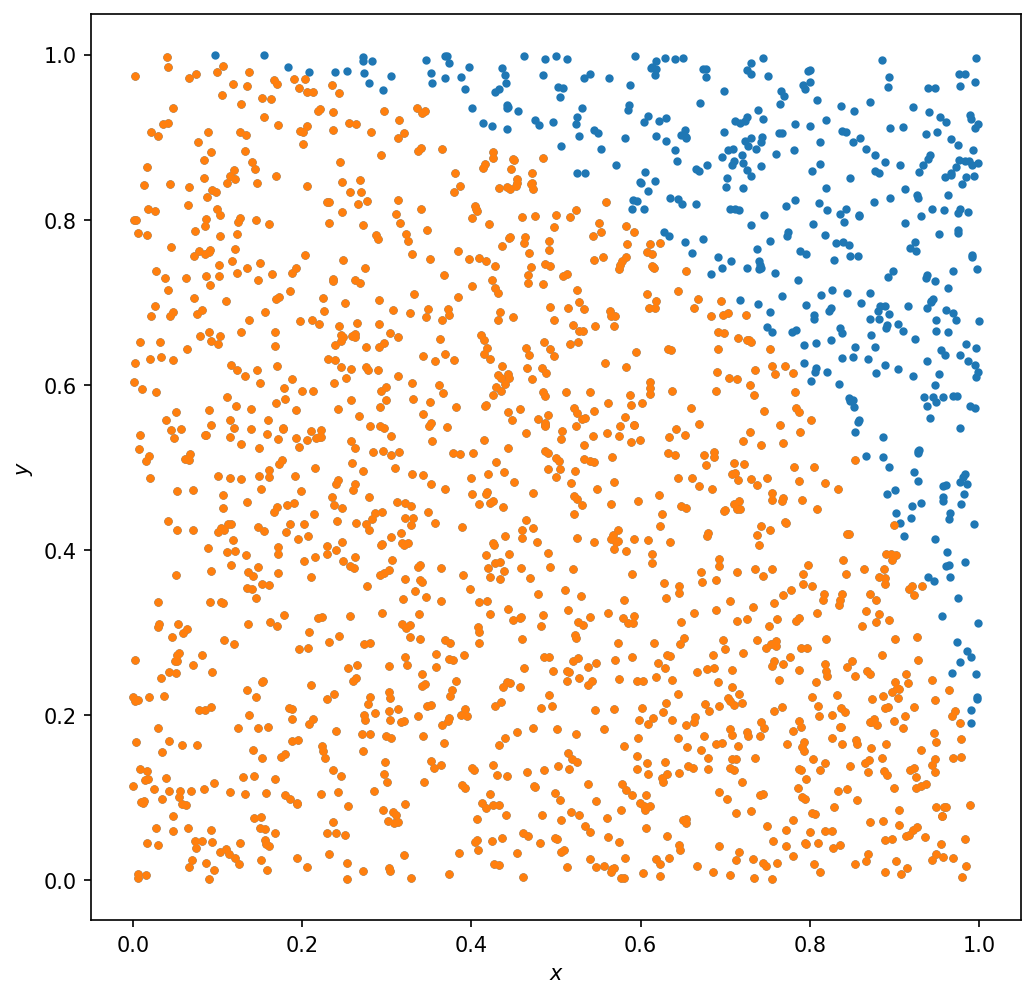

In [68]:
plt.figure(1, figsize=(8,8), dpi=150)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

lessp = p[:,0:-1:100]
idx = lessp[0,:]**2 + lessp[1,:]**2 <= R**2

plt.plot(lessp[0,:],lessp[1,:],'.')
plt.plot(lessp[0,idx],lessp[1,idx],'.')


In [156]:
#3D MC uniform sampling
d = 3

Nsamples = 183995879
M=10

res = np.array([])
for seed in range(M):

    rng = np.random.default_rng()

    #generate random samples
    p = rng.uniform(0,R, size= (d,Nsamples))
    
    #count how many are inside the n-ball
    inside = ((p**2).sum(axis=0) <= R**2).sum()
    V0 = R**d
    res = np.append(res, inside/Nsamples*V0)
    
print("Mean = " + str(res.mean()) ) 
print("BSE = " + str(res.std()/np.sqrt(M)) )

#volume of d-ball in first quadrant
voln = math.pi**(d/2) * R**d / special.gamma(d/2 + 1) / 2**d
print( "Expected = " +  str(voln) )

print("neval = " + str(Nsamples*M) )

Mean = 0.5235981105859443
BSE = 8.05996232665892e-06
Expected = 0.5235987755982989
neval = 1839958790


## The Central Limit Theorem

We have just established that random (uniform) sampling could be very helpful for evaluating multi-dimensional integrals, in comparison to numerical quadrature. But there are situations in which uniform sampling could be highly wateful too. For example, when $f(\textbf x)$ is localized in a small volume in the $3N$ dimensional space. In that case, many of our uniform samples will not be counted when evaluating the integral. 

Note that this is not the case for the example of the n-ball above. For the n-ball, the volume grows like $\sim R^d$ where $d$ is the number of spatial dimensions. We sample uniformy in an $d$-dimensional cube, whose volume also scales the same. This means that the ratio of the two volumes does not depend on $d$. 

For the problematic, localized case, can we do better than uniform sampling? Yes! If we know how to generate samples that are already distributed according to $f(\textbf x)$.

At this point, we will *assume* that we have an algorithm for obtaining a set of $M$ **independent** samples (configurations of the system) $\textbf x_1 ,..., \textbf x_M$ that are all **identically distributed** according to $f(\textbf x)$ with some mean $\langle a \rangle_f$ and variance $\sigma^2 = \langle a^2 \rangle_f - \langle a \rangle_f^2$. This is by no means a trivial task. It is straightforward only for simple distributions and the form of Monte Carlo that we will study next was designed to address exactly this problem. But, for now, we will simply assume such an algorithm exists. If that is the case, we can then evaluate $a(\textbf{x}_j)$ for each sample. 

The central limit theorem (CLT) ensures that if we consider the simple arithmetic mean of the samples as a random variable,

$$
A_M = \frac{1}{M} \sum_{j=1}^{M} a(\textbf{x}_j).
$$ (mean)
It will be normally distributed with the same mean $ \langle a \rangle_f $ as the samples $ \textbf{x}_j $ and a variance 

$$
\sigma^2_M = \frac{\sigma^2}{M}
$$

In other words, the CLT guarantees that the arithmetic mean of the samples converges to ensemble average of $A$ in the limit $M \to \infty$, because its variance from the mean decays like $M^{-1}$. Note that the CLT does not assume a specific form of the distribution $f(\textbf{x})$. This is very powerful, it means that even when our sampling algorithm (dynamic or not) provides samples from a nonuniform distribution, the arithmetic mean will still converge to the true expectation value. An important outcome is that we can use the simple arithmetic mean of the samples to calculate expectation values for the canonical ensemble, just like in the NVE ensemble, as long as we can generate samples from the desired distribution.

However, that is exactly where things get tricky! We know how to generate random samples only from relatively simple probability distributions (Gaussian, uniform, exponential, see others [here](https://numpy.org/doc/1.16/reference/routines.random.html)). 

There are two solutions to this problem: 1) Use a different distribution, $h(\textbf x)$, that is simple enough to be sampled directly and resembles $f(\textbf x)$ better than a uniform distribution. 2) Generate samples consecutively (and not all together at random as we did above) in a process that is sure to converge to the distribution $f(\textbf x)$. The first solution is called **importance sampling**, which we describe first. The second solution, called the **Metropolis Monte Carlo** or **Markov Chain Monte Carlo**, will be discussed in the next section.

## Importance Sampling

We can use the CLT even if we do not know how to sample from $f(\textbf x)$ directly, but know how to sample a different distribution, $h(\textbf x)$, that has much more substantial overlap with $f(\textbf x)$ than the uniform distribution. Since $h(\textbf x)$ is a positive, normalized probability density, we rewrite Eq. [](expval) as

$$
A = \langle a \rangle_f = \int h(\textbf x) \, \frac{f(\textbf x)}{h(\textbf x)} \, a(\textbf{x}) \, \mathrm{d} \textbf{x} = \langle a(\textbf x) w (\textbf x) \rangle_h,
$$(reweight)
where $w(\textbf x) = f(\textbf x) / h(\textbf x)$ is the weight we need associate with every configuration sampled from $h(\textbf x)$ to obtain the expectation value we are really interested in, Eq. [](expval). As a result, this procedure is also often called **reweighting**.

Below we show an example from the book by Tuckerman that uses importance sampling to evaluate the integral

$$
\int_0^1 e^{-x} \, \mathrm{d}x = 1 - \frac{1}{e} = 0.632120558829.
$$

If we sample $x$ uniformly, we get a good estimate of the mean after 1000 random samples.
But the error is an order of magnitude smaller if we use importance sampling with 

$$
h(x) = \frac{1 - ax}{1-\frac{a}{2}},
$$
while choosing $a$ to have the higest similarity between $h(x)$ and $e^{-x}$. The optimal value is $a=0.64$. 

```{admonition} Active learning
:class: tip
Show that $h(x)$ given above is a postive and normalized probability density in the range [0,1].
```

```{admonition} Solution
:class: dropdown

$$
\int_0^1 \frac{1 - ax}{1-\frac{a}{2}} \, \mathrm{d}x = \frac{x - \frac{ax^2}{2}}{1-\frac{a}{2}} \bigg| _0^1 = 1
$$

```

-0.011662666832944757
4.133335709606822


Text(0, 0.5, 'h(x)')

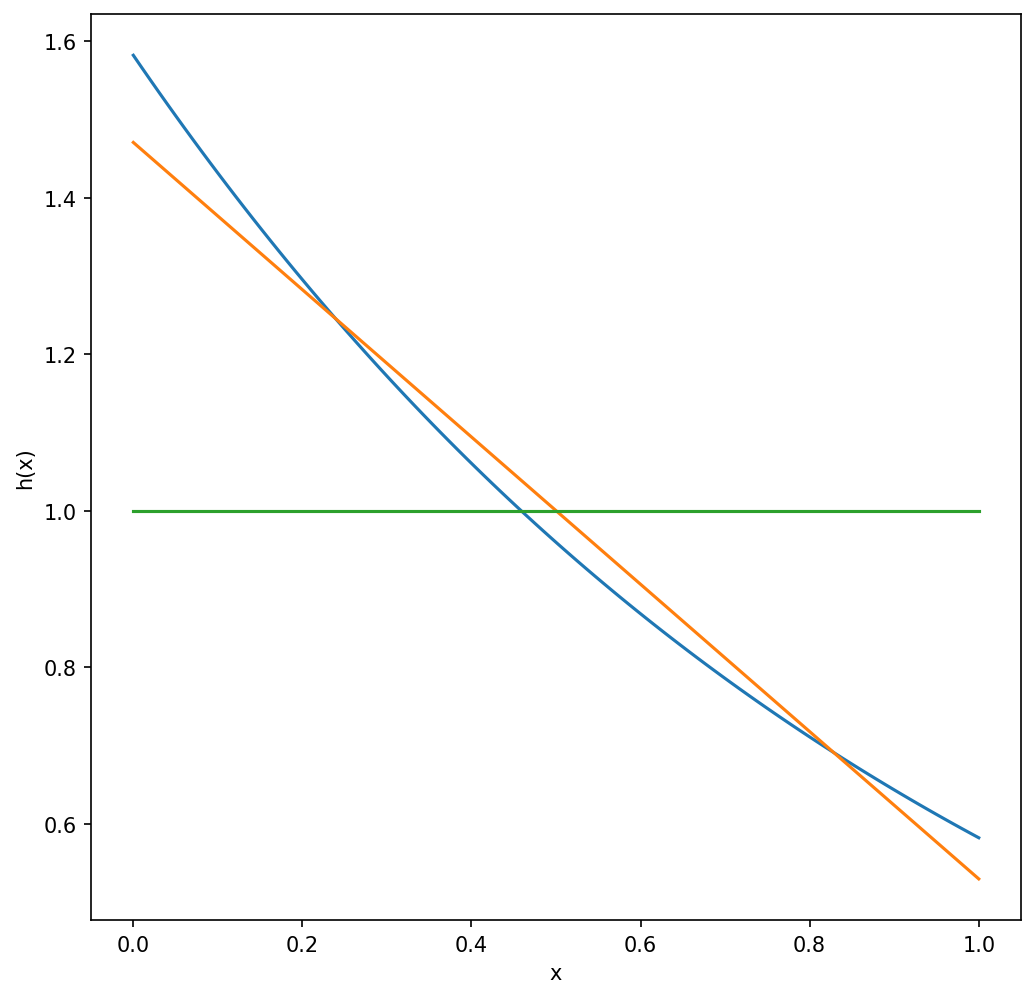

In [26]:
Ng=100; a=0.64

plt.figure(figsize=(8,8), dpi=150)
xg = np.linspace(0,1,Ng)

p = np.exp( -xg ) / np.trapz( x=xg, y=np.exp(-xg) )
q = ( 1 - a*xg )/( 1 - a/2 ) 
q2 = np.ones(Ng)

print(np.sum(special.rel_entr(q,p)))
print(np.sum(special.rel_entr(q2,p)))

plt.plot( xg, p )
plt.plot( xg, q)
plt.plot( xg, q2 )
plt.xlabel(r"x")
plt.ylabel(r"h(x)")

This can be also seen from in final figure, showing the value of the estimator, $e^{-x}$ or $e^{-x}/h(x)$, for the various random samples. It is clear that the standard deviation of the latter is much smaller. Note that if we would have chosen $a=1$, the sampling would actually be worse that for the case of uniform sampling.

uniform mean = 0.6321582931541686
uniform BSE = 0.00014787412340357367
IS mean = 0.6321084884924956
IS BSE = 1.9026027238581034e-05
expected = 0.632120558829


Text(0, 0.5, 'Estimator')

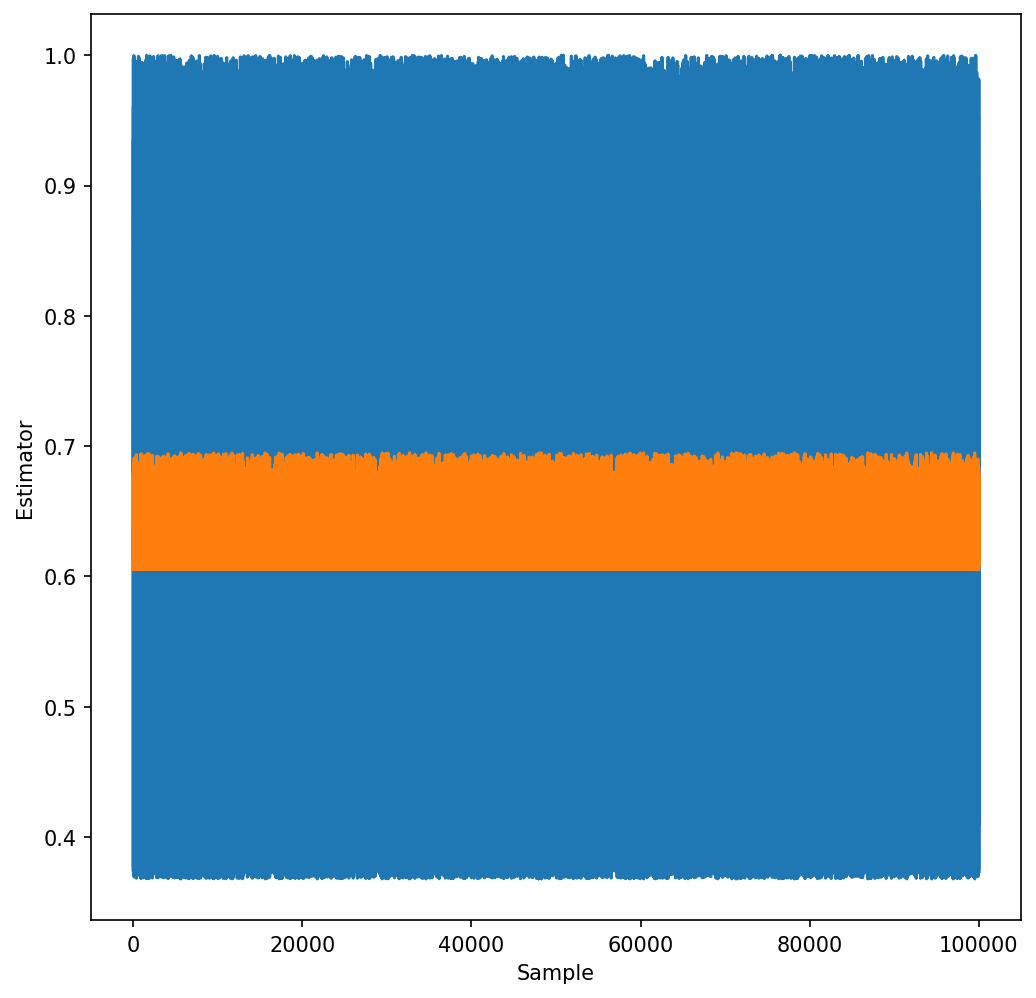

In [25]:
def sampleh(p, a=1):
    
    newp = ( 1 - np.sqrt(1 - ( 1 - a/2 ) * 2 * a * p) ) / a
    h = (1 - a * newp) / ( 1 - a/2 )
    #plt.hist(p[1,:-1:100], bins=20)
    return newp,h

Nsamples = 100000
M=10

res = np.array([])
res_IS = np.array([])
for seed in range(M):

    rng = np.random.default_rng()

    #generate random samples
    p = rng.uniform(0,R, size= Nsamples)
    expp = np.exp(-p)
    
    #append result for this realization
    res = np.append(res, np.mean(expp))
    
    #Sample from h instead
    newp, h = sampleh(p, a=0.64)
    
    #Evaluate new estimator e^-x/h(x)
    expp_h = np.exp(-newp)/h
    
    #append result for this realization
    res_IS = np.append(res_IS, np.mean(expp_h))

print("uniform mean = " + str(res.mean()) ) 
print("uniform BSE = " + str(res.std()/np.sqrt(M)) )

print("IS mean = " + str(res_IS.mean()) ) 
print("IS BSE = " + str(res_IS.std()/np.sqrt(M)) )

print("expected = 0.632120558829")

plt.figure(figsize=(8,8), dpi=150)
plt.plot(expp)
plt.plot(expp_h)
plt.xlabel(r"Sample")
plt.ylabel(r"Estimator")

Finally, we note that importance sampling is useful not only when we do not know how to sample $f(\textbf x)$. For example, when $a(\textbf x)$ is highly oscillatory, with both negative and positive contributions, such that its expctation value results from the near-cancellation of the positive and negative terms. We do not go into detail here, but a judicious choice of $h(\textbf x)$ could significantly improve convergence in such difficult cases. 


## Metropolis Monte Carlo and detailed balance

We already saw that if we have a way to sample $f(\textbf x)$, we can easily obtain expectation values using importance sampling MC. But it is an unfortunate fact that we have efficient algorithms to sample directly only relatively simple distributions, such as exponential, Gaussian, uniform etc. 

In a seminal paper in 1953, [Arianna](https://en.wikipedia.org/wiki/Arianna_W._Rosenbluth) and [Marshall](https://en.wikipedia.org/wiki/Marshall_Rosenbluth) Rosenbluth, [Augusta](https://en.wikipedia.org/wiki/Augusta_H._Teller) and [Edward](https://en.wikipedia.org/wiki/Edward_Teller) Teller, and [Nicholas Metropolis](https://en.wikipedia.org/wiki/Nicholas_Metropolis) (sans spouse) developed an algorithm that, instead of obtaining random samples from $f(\textbf x)$ at once, creates a sequential samples $\textbf{x}_1, \textbf{x}_2, ...$ that converge to the correct $f(\textbf x)$, for an arbitrary distribution function! The importance of this result truly could not be overstated. It is perhaps one of the greatest results of the previous century.

The idea at the core of the algorithm is that we need to specify a rule to generate the next sample $\textbf{x}_{i+1}$ from the current sample $\textbf{x}_i$. A sequence of samples that is generated based on information solely from the previous step is called a **Markov chain**. We denote the probability of obtaining a sample $\textbf x$ from some other sample $\textbf y$ as $R(\textbf x | \textbf y)$. For this probability to be a valid rule for generating a Markov chain, it must satisfy a condition called **detailed balance**,

$$
R(\textbf x | \textbf y) f(\textbf y) = R(\textbf y | \textbf x) f(\textbf x)
$$(detailed_balance)

where $R(\textbf x | \textbf y) f(\textbf y)$ is called the *a priori* probability of moving from $\textbf y$ to $\textbf x$, which is just the probability to move from $\textbf y$ to $\textbf x$, given that the system was already in $\textbf y$. Detailed balance is important, because it guarantees that the Markov chain is microscopically reversible. Then, once a move is generated, we must decide whether to accept it or not. 

The Metropolis MC algorithm states a rule for proposing moves, which we denote as $T(\textbf x | \textbf y)$, which has to be normalized, 

$$
\int T(\textbf x | \textbf y) \, \mathrm{d}x = 1,
$$

and a probability that the move is accepted, which is denoted as $A(\textbf x | \textbf y)$. Then the probability to move from $\textbf y$ to $\textbf x$, is given by the product of the probability of suggesting such a move, times the acceptance probability, i.e.

$$
R(\textbf x | \textbf y) = T(\textbf x | \textbf y) A(\textbf x | \textbf y).
$$

Inserting this equation into the detailed balance conditions, Eq. [](detailed_balance) we get

$$
A(\textbf x | \textbf y) = r(\textbf x | \textbf y) A(\textbf y | \textbf x),
$$
where 

$$
r(\textbf x | \textbf y) = \frac{T(\textbf y | \textbf x) f(\textbf x)}{T(\textbf x | \textbf y) f(\textbf y)}.
$$

Now, suppose $A(\textbf x | \textbf y)=1$ and the move from $\textbf y$ to $\textbf x$ is favorable, then $A(\textbf y | \textbf x) < 1$ and therefore $r(\textbf x | \textbf y) > 1$. However, if $A(\textbf x | \textbf y)<1$, then $A(\textbf y | \textbf x) = 1$ is favorable and so $r(\textbf x | \textbf y) < 1$. We can summarize these findings as

$$
A(\textbf x | \textbf y) = \min[1,r(\textbf x | \textbf y)].
$$(acc_crit)

Now all the ingredients for Metropolis MC are ready! We need to initialzie the system at some configuration $\textbf{x}_k$, then define a probability to make a move $T(\textbf{x}_k | \textbf{x}_{k+1})$, and suggest a step $\textbf{x}_{k+1}$. Next, based on $T(\textbf x | \textbf y)$ and the probability we want to sample, $f(\textbf)$, we evaluate the function $r(\textbf x | \textbf y)$. Finally, we accept or reject the move based on the criterion in Eq. [](acc_crit). The final step is done in practice in the following way: If $r(\textbf x | \textbf y) \le 1$ the move is accepted. If it is smaller than 1, a random number is sampled from a uniform distribution between $[0,1]$. If it is smaller than $r(\textbf x | \textbf y)$, the move is accepted. Otherwise, the move is rejected.

## MC moves and acceptance ratio

translation.

## Sampling other ensembles

isothermal-isobaric, grand canonical?